In [1]:
from typing import TypedDict, Optional

class MyState(TypedDict):
    user_query: str
    rewritten_query: Optional[str]
    need_internet_search: Optional[bool]
    search_results: Optional[str]
    final_answer: Optional[str]
    bad_state: Optional[bool]
    query_intent: Optional[str]
    user_phone_num: Optional[str]
    user_order_id: Optional[str]
    order_operation: Optional[str]

In [2]:
### part 1 delopment ###

from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Access the environment variable
together_api = os.environ.get('TOGETHER_API_KEY')

from langchain_openai import ChatOpenAI

TOGETHER_AI_BASE_URL = "https://api.together.xyz/v1"

llm = ChatOpenAI(
    model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
    base_url=TOGETHER_AI_BASE_URL,
    api_key=together_api
)

    
def node_query_rewrite(state: MyState) -> MyState:
    """
    Rewrites the user's query using an LLM for clarity or correctness.
    Sanitizes the rewritten query to ensure compatibility with the search engine.
    """
    print("---Node Query Rewrite---")
    user_query = state["user_query"]
    
    # Prompt to rewrite the query
    rewrite_prompt = f"Please rewrite this query suitable for search engines. Ensure it is clear and concise:\n\n{user_query}"
    
    # Invoke the LLM to rewrite the query
    rewritten = llm.invoke(rewrite_prompt).content
    print("Raw rewritten query from LLM:", rewritten)
    
    # Sanitize the rewritten query
    def sanitize_query(query: str) -> str:
        import re
        # Allow only alphanumeric characters, spaces, and basic punctuation (e.g., single quotes, dashes)
        return re.sub(r'[^a-zA-Z0-9\s\'-]', '', query).strip()
    
    sanitized_query = sanitize_query(rewritten)
    print("Sanitized query:", sanitized_query)
    
    # Update the state with the sanitized query
    state["rewritten_query"] = sanitized_query
    return state


from langchain_core.messages import HumanMessage, SystemMessage
import nest_asyncio
from llama_parse import LlamaParse
from llama_index.core import SimpleDirectoryReader
from langchain_text_splitters import RecursiveCharacterTextSplitter
import lancedb
from lancedb.embeddings import get_registry
from lancedb.pydantic import LanceModel, Vector
import pandas as pd

nest_asyncio.apply()
db = lancedb.connect(".lancedb")
pdf_files = ["../assets/The New Complete Book of Foos.pdf"]
llama_pase_api = os.environ.get("LLAMA_PARSE_API_KEY")

parser = LlamaParse(result_type="text", api_key=llama_pase_api)
file_extractor = {".pdf": parser}
data_for_parse = SimpleDirectoryReader(input_files=pdf_files, file_extractor=file_extractor)
documents =data_for_parse.load_data()

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1024,
    chunk_overlap=64,
    length_function=len,
    is_separator_regex=False,
)

documents_list = []
page_number = 0
last_doc = None
for doc in documents:
    if last_doc is None or last_doc != doc.metadata["file_name"]:
        page_number = 1
        last_doc = doc.metadata["file_name"]
    else:
        page_number += 1

    texts = text_splitter.split_text(doc.text)
    for text in texts:
        item = {}
        item["id_"] = doc.id_
        item["text"] = text
        item["metadata_file_name"] = doc.metadata["file_name"]
        item["metadata_creation_date"] = doc.metadata["creation_date"]
        item["metadata_pagenumber"] = page_number
        documents_list.append(item)


embedding_model = get_registry().get("sentence-transformers").create(name="BAAI/bge-small-en-v1.5")

class ChunksOfData(LanceModel):
    id_: str
    text: str = embedding_model.SourceField()  # Store text data for search
    metadata_file_name: str
    metadata_creation_date: str
    metadata_pagenumber: int
    vector: Vector(embedding_model.ndims()) = embedding_model.VectorField()  # type: ignore
    
df = pd.DataFrame(documents_list)

def df_to_dict_batches(df: pd.DataFrame, batch_size: int = 128):
    """
    Yields data from a DataFrame in batches of dictionaries.
    Each batch is a list of dict, suitable for LanceDB ingestion.
    """
    for start_idx in range(0, len(df), batch_size):
        end_idx = start_idx + batch_size
        # Convert the batch of rows to a list of dict
        batch_dicts = df.iloc[start_idx:end_idx].to_dict(orient="records")
        yield batch_dicts
        
# Check if the table already exists in the database
if "embedded_chunks3" in db.table_names():
    tbl = db.open_table("embedded_chunks3")
    print("Table 'embedded_chunks3' loaded successfully.")
else:
    print("Table 'embedded_chunks3' not found. Creating a new one...")
    tbl = db.create_table(
        "embedded_chunks3",
        data=df_to_dict_batches(df, batch_size=10),
        schema=ChunksOfData,
    )
    tbl.create_fts_index("text")
    print("Table 'embedded_chunks3' created successfully.")


def node_search_book(state: MyState) -> MyState:
    """
    search from the book
    """
    print("---Node Search the book---")
    query = state["rewritten_query"]
    
    context_list = tbl.search(query, query_type="hybrid").limit(5).to_list()
    context = ''.join([f"{c['text']}\n\n" for c in context_list])
    
    system_prompt = "Answer user query based on the given context.if context is not related, just write: unrelated"
    user_prompt = f"Question:\n{query}\nContext:\n{context}"

    messages = [
        SystemMessage(system_prompt),
        HumanMessage(user_prompt),
    ]
    
    results = llm.invoke(messages)
    
    if results.content.lower() == "unrelated":
        state["need_internet_search"] = True
    else:
        state["need_internet_search"] = False
        state['search_results'] = results
    
    return state


from langchain_community.tools.tavily_search import TavilySearchResults

tavily_api = os.environ.get("TAVILY_API_KEY")


def node_search_internet(state: MyState) -> MyState:
    """
    Searches the internet for the rewritten query using a search tool.
    """
    if state.get("need_internet_search", False):
        print("---Node Search Internet---")
        rewritten_query = state["rewritten_query"]
    
        # Use your search tool function
        results = TavilySearchResults(max_results=3, tavily_api_key=tavily_api).invoke(rewritten_query)
        print("Search results:")
        print(results)
        # Save the search results in state
        state["search_results"] = str(results)
        
    return state


def node_generate_answer(state: MyState) -> MyState:
    """
    Generates a final answer based on the original user query and the search results.
    """
    print("---Node Generate Answer---")
    user_query = state["user_query"]
    search_info = state.get("search_results", "No search results found.")
    # search_info = state["search_results"] or "No search results found."
    # Combine user query with search results to generate answer
    try:
        
        if not state["bad_state"]:
            final_answer = llm.invoke(
                f"User's query: {user_query}\n\nSearch results:\n{search_info}\n\n"
                "Please provide a helpful answer."
            )
            print("Final answer:", final_answer.content)
            state["final_answer"] = final_answer.content
        
        
        else:
            print("sorry i can't give services.")
            state["final_answer"] = "Not related Query!"
    except Exception as e:
        print(f"Error during answer generation: {e}")
        state["final_answer"] = "Sorry, there was an issue generating the answer."
    return state

/home/davinci/GitHub/JANJAN/lxms/apps/chatfood/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Started parsing the file under job_id 61c9ed5b-0426-413f-9efe-2fd3c34d4f18
Table 'embedded_chunks3' loaded successfully.


In [3]:
from typing import Literal
from pydantic import BaseModel, Field

class IsRelated(BaseModel):
    reasoning: str = Field(description="The reasoning behind the decision, whether the query is related to restaurants and foods or not.")
    is_related_flag: bool = Field(description="The decision whether the query is related to restaurants and foods or not.")

def is_related(state: MyState) -> Literal["node_intent_identifier", "node_update_bad_state"]:
    query = state["user_query"]
    llm_with_structured_output = llm.with_structured_output(IsRelated)
    try:
        prompt = (
            f"Analyze the following query and decide whether it is related to restaurants or foods. "
            "Respond in this exact JSON format: "
            '{"reasoning": "<reasoning string>", "is_related_flag": <true|false>}.\n\n'
            f"Query: {query}"
        )
        
        response = llm_with_structured_output.invoke(prompt)
        if response and hasattr(response, 'is_related_flag') and isinstance(response.is_related_flag, bool):
            print("-----Is Related-----")
            print(response)
            if response.is_related_flag:
                return "node_intent_identifier"
            else:
                return "node_update_bad_state"  # A node to update `bad_state`
        else:
            print("Invalid response structure.")
            return "node_update_bad_state"
    except Exception as e:
        print(f"Error invoking LLM: {e}")
        return "node_update_bad_state"
    
def node_update_bad_state(state: MyState) -> MyState:
    """
    Updates the state to indicate a 'bad state' when the query is not related.
    """
    state["bad_state"] = True
    return state

In [4]:
def function_switcher(state: MyState) -> Literal["node_query_rewrite", "node_order_operation"]:
    """
    Determines the next node based on the intent identified in the state.
    """
    query_intent = state.get("query_intent", None)  # Retrieve the intent from the state
    
    if query_intent == "general_food":
        return "node_query_rewrite"  # Route to the general query handling node
    elif query_intent == "order_operation":
        return "node_order_operation"  # Route to the order operation handling node
    else:
        raise ValueError("Unknown or missing query intent in state.")  # Handle unexpected cases

In [5]:
def node_intent_identifier(state: MyState):
    query = state['user_query']
    
    print("--- INTENT IDENTIFY ---")
    prompt = f"""Based on the query, determine the purpose or intent of the query. \n\n query:\n {query} \n\n
    If it is related to general questions about food (e.g., what it is or how it is made), respond with general_food. 
    If it is related to orders (e.g., placing, tracking, or modifying orders), respond with order_operation. just write order_operation or general_food not more!"""
    
    result = llm.invoke(prompt)
    if result.content.lower() == 'general_food':
        state['query_intent'] = 'general_food'
    if result.content.lower() == 'order_operation':
        state['query_intent'] = 'order_operation'
    
    return state

In [6]:
import re

def node_extract_info_from_user_query(state: MyState):
    print("------------- getting info from user -------------------")
    inputs_are_ok = False
    query = ""
    validated_phone_number = ""
    validated_order_id = ""
    print("please enter your phone number: (10 digit)")
    phone_num = input()
    query += "phone_number: " + phone_num + "\n"
    print("and also please enter your order id:")
    order_id = input()
    query += "order_id: " + order_id

    extractor_prompt = f"""Extract the phone number and order ID from the query.\n query: \n{query}\n\n 
    Validate the phone number to ensure it is in a valid format (e.g., 10 digits for standard phone numbers). 
    Validate the order ID to ensure it meets the required format (e.g., alphanumeric, specific length). 
    Return the output in the format: phone_number-order_id. If either the phone number or order ID is invalid, 
    return invalid for that field. do not write explanation or anything more."""

    extraction_result = llm.invoke(extractor_prompt)
    pattern = r"^(?P<phone_number>(\d{10}|invalid))-(?P<order_id>([A-Za-z0-9]+|invalid))$"
    match = re.match(pattern, extraction_result.content)
    if match:
        validated_phone_number = match.group("phone_number")
        validated_order_id = match.group("order_id")
        if validated_phone_number != 'invalid' and validated_order_id != 'invalid':
                inputs_are_ok = True

    while not inputs_are_ok:
        query = ""
        print("Your input is not valid, be careful and enter again:")
        print("enter phone number: ")
        phone_num = input()
        query += "phone_number: " + phone_num + "\n"
        print("enter order id: ")
        order_id = input()
        query += "order_id: " + order_id
        extractor_prompt = f"""Extract the phone number and order ID from the query.\n query: \n{query}\n\n 
        Validate the phone number to ensure it is in a valid format (e.g., 10 digits for standard phone numbers). 
        Validate the order ID to ensure it meets the required format (e.g., alphanumeric, specific length). 
        Return the output in the format: phone_number-order_id. If either the phone number or order ID is invalid, 
        return invalid for that field. do not write explanation or anything more."""
        extraction_result = llm.invoke(extractor_prompt)
        match = re.match(pattern, extraction_result.content)
        if match:
            validated_phone_number = match.group("phone_number")
            validated_order_id = match.group("order_id")
            if validated_phone_number != 'invalid' and validated_order_id != 'invalid':
                inputs_are_ok = True
    
    
    state["user_phone_num"] = validated_phone_number
    state["user_order_id"] = validated_order_id
    
    return state

In [7]:
from db_manager import *

def node_order_operation(state: MyState):
    query = state['user_query']
    print("------------ node order operation --------------------")
    prompt = f"""You are a switcher. Based on the user query, determine which function should be called. The available functions are:

                comment_order(order_id, person_name, comment): Use this if the query is about adding a comment to an order.

                check_order_status(order_id): Use this if the query is about checking the status of an order.

                cancel_order(order_id, phone_number): Use this if the query is about canceling an order.
                
                query: {query}

                Analyze the query and respond with only the name of the appropriate function. Do not include any additional text or explanation."""
    
    result = llm.invoke(prompt).content
    
    if result == "comment_order":
        state['order_operation'] = "commet_order"
    if result == "check_order_status":
        state["order_operation"] = "check_order_status"
    if result == "cancel_order":
        state["order_operation"] = "cancel_order"
        
    return state

In [8]:
def node_cancel_order(state: MyState):
    phone_number = state['user_phone_num']
    result = cancel_order(state['user_order_id'], f"{phone_number[:3]}-{phone_number[3:6]}-{phone_number[6:]}")
    print("----- order cancelation --------")
    print(result)
    print("---------------------------------")

def node_check_order_status(state: MyState):
    result = check_order_status(state['user_order_id'])
    print("-------------- check order status -----------------------")
    print(result)
    print("-----------------------------------------------------------")

def node_comment_order(state: MyState):
    print("please enter your name:")
    name = input()
    print("please enter your comment:")
    comment = input()
    result = comment_order(state["user_order_id"], name, comment)
    print("------------------ comment order -------------------------------")
    print(result)
    print("--------------------------------------------------------------")

In [9]:
def order_operation_switcher(state: MyState)-> Literal["node_cancel_order", "node_check_order_status", "node_comment_order"]:
    order_operation = state['order_operation']
    
    if order_operation == "cancel_order":
        return "node_cancel_order"
    if order_operation == "check_order_status":
        return "node_check_order_status"
    if order_operation == "comment_order":
        return "node_comment_order"
    

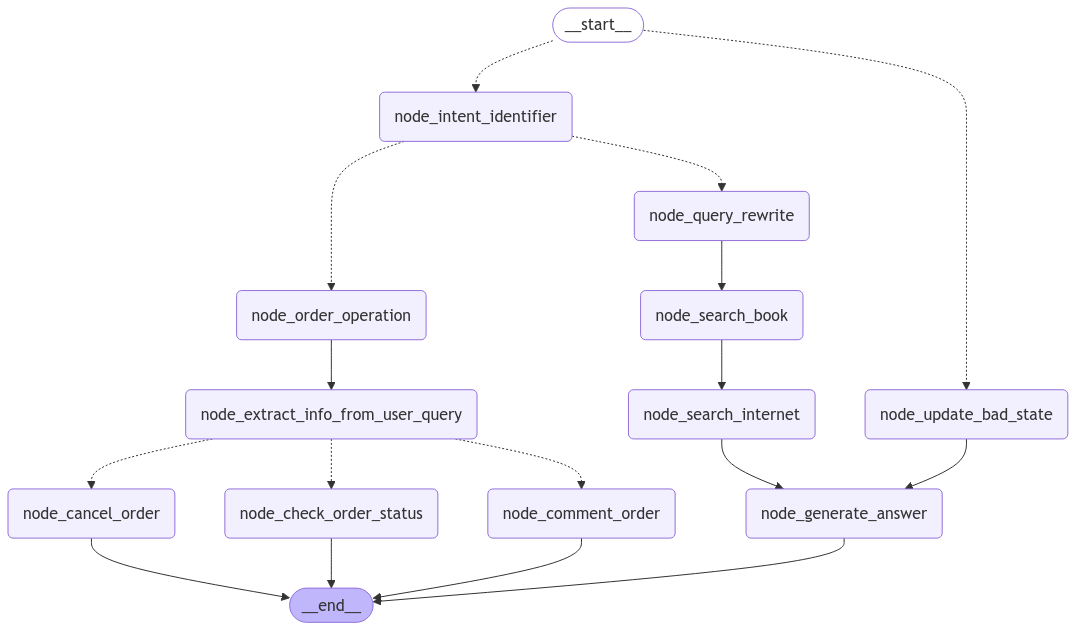

In [10]:
from langgraph.graph import StateGraph, START, END

# Build the graph
builder = StateGraph(MyState)

# Add nodes
builder.add_node("node_query_rewrite", node_query_rewrite)
builder.add_node("node_search_book", node_search_book)
builder.add_node("node_search_internet", node_search_internet)
builder.add_node("node_generate_answer", node_generate_answer)
builder.add_node("node_update_bad_state", node_update_bad_state)
builder.add_node("node_intent_identifier", node_intent_identifier)
builder.add_node("node_order_operation", node_order_operation)
builder.add_node("node_extract_info_from_user_query", node_extract_info_from_user_query)
builder.add_node("node_cancel_order", node_cancel_order)
builder.add_node("node_check_order_status", node_check_order_status)
builder.add_node("node_comment_order", node_comment_order)


# Add edges (linear flow)
builder.add_conditional_edges(START, is_related)
builder.add_conditional_edges("node_intent_identifier", function_switcher)
builder.add_conditional_edges("node_extract_info_from_user_query", order_operation_switcher)

builder.add_edge("node_update_bad_state", "node_generate_answer")
builder.add_edge("node_query_rewrite", "node_search_book")
builder.add_edge("node_search_book", "node_search_internet")
builder.add_edge("node_search_internet", "node_generate_answer")
builder.add_edge("node_generate_answer", END)

builder.add_edge("node_order_operation", "node_extract_info_from_user_query")
builder.add_edge("node_comment_order", END)
builder.add_edge("node_check_order_status", END)
builder.add_edge("node_cancel_order", END)

# Compile the graph
advanced_search_graph = builder.compile()

from IPython.display import Image, display

display(Image(advanced_search_graph.get_graph().draw_mermaid_png()))

In [13]:
state = {
    "user_query": "i want to cancel my order.",
    "rewritten_query": None,
    "need_internet_search": None,
    "search_results": None,
    "bad_state": None,
    "final_answer": None,
}

final_state = advanced_search_graph.invoke(state)

print(final_state['final_answer'])

-----Is Related-----
reasoning="The query mentions 'cancel my order', which is an action typically associated with purchasing or takeout services, often related to restaurants or food delivery." is_related_flag=True
--- INTENT IDENTIFY ---
------------ node order operation --------------------
------------- getting info from user -------------------
please enter your phone number: (10 digit)
and also please enter your order id:
----- order cancelation --------
Order ID 69 from 109-432-8767 has been successfully canceled.
---------------------------------
None
